**Overview of `02_vit_training_trials_aug_tl_kt_256.ipynb`**

This notebook conducts an end-to-end investigation of Vision Transformer (ViT)–based classification for the BirdCLEF-2025 challenge, combining spectrogram inputs with metadata and Keras Tuner–driven hyperparameter optimization. It is organized as follows:

1. **Configuration & Flags**

   * Selector switches control augmentation, transfer learning, class weights, and tuner usage
   * Core parameters (input resolution, batch size, learning-rate bounds, number of folds, etc.) are defined up front

2. **Data Loading & Preprocessing**

   * Load precomputed mel-spectrogram arrays
   * Extract, scale, and one-hot encode geospatial and behavioral metadata
   * Build balanced training and validation splits, compute oversampling caps and class weights

3. **Hyperparameter Search**

   * Define a search space for learning rate, dropout rate, backbone-unfreeze schedule, and weight decay
   * Run a Hyperband search to identify the optimal combination
   * Persist the best hyperparameters for downstream experiments

4. **Cross-Validation with Best Hyperparameters**

   * Apply 5-fold stratified cross-validation using the previously found settings
   * Aggregate fold-level metrics (best epoch, loss, accuracy, macro-F1) into a summary table

5. **Final Model Evaluation**

   * Retrain on full training set with best hyperparameters
   * Evaluate on held-out test data, reporting confusion matrices, per-class F1 scores, and probability distributions

6. **Key Notes & Best Practices**

   * ViT models require careful VRAM management; freezing backbone often preserves generalization
   * Oversampling capped at 50× plus on-the-fly spectrogram masking consistently outperforms heavy class-weighting
   * Custom callbacks unfreeze the transformer backbone after a user-defined number of epochs without manual intervention

7. **Extensions & Customization**

   * Easily swap in alternative backbones (e.g. EfficientNet) or add additional audio channels (Chroma, MFCC)
   * Tweak augmentation pipelines or incorporate attention mechanisms in metadata fusion


In [1]:
# Import common modules and set global configs
from project_utils.common_imports import *

# Specific imports for data, augmentation, model, and evaluation
from project_utils.loading_utils import main_data_processing_pipeline, preprocess_metadata
from project_utils.data_augmentor_and_generator import data_generator, data_generator_with_metadata, SpecTimeMask, SpecFreqMask, get_steps
from project_utils.model_architect import get_vit_model, macro_f1_fn, categorical_focal_loss, UnfreezeBackbone, get_cosine_decay_scheduler, AddClsToken, SafeCheckpointTuner, get_multimodal_vit_model
from project_utils.tuner_utils import run_multimodal_tuner
from project_utils.cv_utils import cross_validate_best_hp
from project_utils.evaluation_utils import evaluate_on_test, evaluate_on_test_multimodal, plot_training_diagnostics, plot_test_evaluation, CLASS_MAPPING_DICT

# System info
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2025-08-07 09:53:53.074118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 09:53:53.089709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754585633.105266 2085687 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754585633.109942 2085687 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754585633.121816 2085687 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPUs available: 1


In [ ]:
class CFG:
    # ─── Static defaults ────────────────────────────────────────────────────────
    seed = 42
    debug = False
    print_freq = 10000
    num_workers = 1

    # Parametric settings
    model_type = "vit" # vit or rescnn
    input_dim = 256             # can be 32, 64, 256, etc.
    train_model = True
    use_augmentation   = True
    use_oversampling   = False
    use_class_weights  = True
    use_transfer_learning = True
    use_tuner = True

    # Training hyperparams
    epochs = 15  # Increase for main training; tuner will use up to this
    batch_size   = 8
    lr           = 8.24e-4  # Tuned value (rounded from 0.000824)
    weight_decay = 7.55e-6  # Tuned value (rounded from 7.55e-6)
    min_lr       = 1e-6
    dropout_rate = 0.2

    # Cross-validation
    n_fold         = 5

    # Model / data specifics
    in_channels = 1
    num_classes = 4
    freeze_epochs = 0

    # Augmentation params (adjusted dynamically below)
    noise_std      = 0.1
    max_time_shift = 0.2
    max_freq_shift = 0.2
    max_mask_time  = 0.15
    max_mask_freq  = 0.15

    # Metadata features
    metadata_dim = 15

    # ─── Paths ───────────────────────────────────────────────────────────────────
    PROJECT_ROOT_DIR = Path.cwd().parents[2]
    OUTPUT_DIR       = PROJECT_ROOT_DIR / "data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR / "birdclef25-mel-spectrograms"

    working_df_path  = PROJECT_ROOT_DIR / "data/raw/downsampled_metadata.csv"

    MODELS_DIR     = OUTPUT_DIR / "models"
    PLOTS_DIR      = OUTPUT_DIR / "plots"
    RESULTS_CSV_DIR= OUTPUT_DIR / "result_csvs"

    # ─── Initialization ──────────────────────────────────────────────────────────
    def __init__(self):

        # Minimal seed setting
        os.environ['PYTHONHASHSEED'] = str(self.seed)  # For hash consistency (e.g., dict ordering)
        random.seed(self.seed)                         # Python random
        np.random.seed(self.seed)                      # NumPy random
        tf.random.set_seed(self.seed)                  # TensorFlow/Keras global seed

        # 1) Create dirs
        for d in (self.MODELS_DIR, self.PLOTS_DIR, self.RESULTS_CSV_DIR):
            os.makedirs(d, exist_ok=True)

        # 2) Fix augmentation-dependent params
        if self.use_augmentation:
            self.aug_prob    = 1
            self.mixup_alpha = 0.2

            # Set size-specific augmentation params
            if self.input_dim == 32:
                self.noise_std      = 0.065
                self.max_time_shift = 0.11
                self.max_freq_shift = 0.065
                self.max_mask_time  = 0.125
                self.max_mask_freq  = 0.1
            elif self.input_dim == 64:
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
            else:
                # Fallback for other sizes (e.g., 256); use 64x64 values
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135

        # 3) Set target shape (unchanged)
        self.TARGET_SHAPE = (self.input_dim, self.input_dim)


        # ─── Derived properties ─────────────────────────────────────────────────────
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f"birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy"

    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:      suffix += "_aug"
        if self.use_oversampling:      suffix += "_os"
        if self.use_class_weights:     suffix += "_cw"
        if self.use_transfer_learning: suffix += "_tl"
        if self.model_type.lower() == "vit":
            return f"vit_model_{self.input_dim}{suffix}.keras"
        elif self.model_type.lower() == "rescnn":
            return f"rescnn_model_{self.input_dim}{suffix}.keras"
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}. Use 'vit' or 'rescnn'.")

cfg = CFG()

In [3]:
f'best_{cfg.model_save_name}'

'best_vit_model_256_aug_cw_tl.keras'

In [4]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (256, 256)


In [5]:
# Run the main pipeline to load data, compute factors/weights, and inspect
combined_train_val_df, test_df, class_weights_dict, filtered_spectrograms = main_data_processing_pipeline(
    cfg, spectrograms, data_generator
)

# For generator usage
class_weights = class_weights_dict if cfg.use_class_weights else None

metadata_features = preprocess_metadata(combined_train_val_df, cfg)

# Manage memory usage
del spectrograms
gc.collect()

display(combined_train_val_df.head(3))  # Display first 3 rows for inspection


Loading full dataset...
Train/Val samples: 332
Test samples: 68
Filtered spectrograms to 400 entries
Class counts in train/val: {0: 87, 1: 84, 2: 81, 3: 80}
Computed oversampling factors: {0: 1, 1: 1, 2: 1, 3: 1}

Full dataset class distribution:
 0: Amphibia - 87 samples (26.2%)
 1: Aves - 84 samples (25.3%)
 2: Insecta - 81 samples (24.4%)
 3: Mammalia - 80 samples (24.1%)
Imbalance ratio: Aves / Total = 25.30%

Computing balanced class weights...
Final class weights: {0: 0.9540229885057471, 1: 0.9880952380952381, 2: 1.0246913580246915, 3: 1.0375}

Inspecting one batch from the data generator:
Batch shape: (32, 256, 256, 1)
Example batch labels (one-hot): [[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.5861962e-01 0.0000000e+00 0.0000000e+00 4.4138035e-01]
 [1.2031597e-05 0.0000000e+00 0.0000000e+00 9.9998796e-01]
 [0.0000000e+00 9.5782000e-01 4.2180005e-02 0.0000000e+00]
 [0.0000000e+00 7.4239403e-01 2.5760594e-01 0.0000000e+00]
 [0.0000000e+00 7.2561431e-01 0.000000

,primary_label,scientific_name,common_name,class_name,longitude,latitude,class,y_species_encoded,split,filename,has_uncertain,category,song/canto,call,uncertain,mating/groups,hatching,immitation,noise/drum,samplename
0,787625,Leucostethus fraterdanieli,Santa Rita Rocket Frog,Amphibia,-75.5153,6.2551,Amphibia,0,train,787625/iNat48805.ogg,False,other,False,False,False,False,False,False,False,787625-iNat48805
1,66531,Pristimantis achatinus,Cachabi Robber Frog,Amphibia,-76.0161,5.7858,Amphibia,0,train,66531/iNat445441.ogg,False,other,False,False,False,False,False,False,False,66531-iNat445441
2,555142,Boana pugnax,Chirique-Flusse Tree Frog,Amphibia,-80.9382,8.0390,Amphibia,0,train,555142/iNat1258897.ogg,False,other,False,False,False,False,False,False,False,555142-iNat1258897


In [6]:
# Split train / val inside the notebook (80-20 stratified)
train_df, val_df = train_test_split(
    combined_train_val_df,
    test_size=0.20,
    stratify=combined_train_val_df["y_species_encoded"],
    random_state=42,
)

best_model, tuner = run_multimodal_tuner(
    cfg, train_df, val_df,
    filtered_spectrograms,        # you created this earlier
    metadata_features,
    class_weights,
)

Trial 157 Complete [00h 01m 36s]
val_macro_f1_fn: 0.7408729791641235

Best val_macro_f1_fn So Far: 0.8633597493171692
Total elapsed time: 09h 31m 26s
✅  Search finished!
Best model saved ➜  /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/vit_model_256_aug_cw_tl_tuner/best_vit_model_256_aug_cw_tl.keras
Best hyperparameters saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/vit_model_256_aug_cw_tl_tuner/best_hps_vit_model_256_aug_cw_tl.json


Model: "multimodal_vit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meta_input          │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,048 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_input          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_branch       │ (None, 768)       │ 85,798,656 │ spec_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_layer        │ (None, 832)       │          0 │ vision_branch[0]… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    213,248 │ fusion_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 4)         │      1,028 │ dropout_14[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 86,023,748 (328.15 MB)

 Trainable params: 224,836 (878.27 KB)

 Non-trainable params: 85,798,912 (327.30 MB)

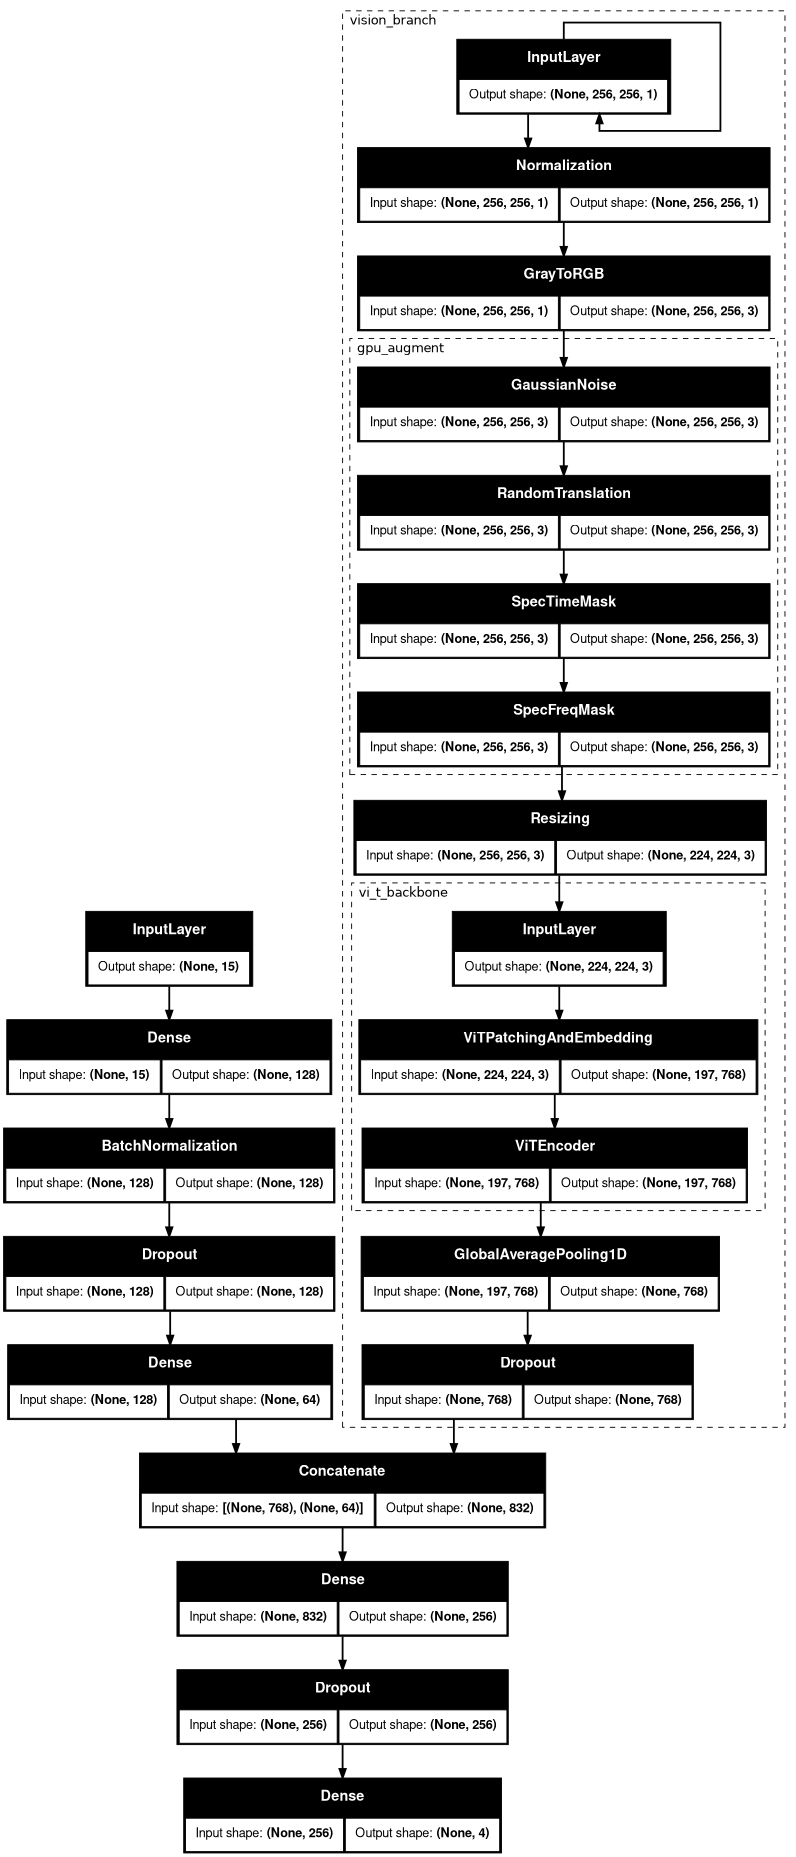

In [15]:
best_model.summary()
from tensorflow.keras.utils import plot_model
plot_model(best_model, show_shapes=True, expand_nested=True, dpi=65)

In [16]:
hp_json_path = cfg.OUTPUT_DIR / f'{cfg.model_save_name.replace(".keras", "")}_tuner' / f"best_hps_{cfg.model_save_name.replace('.keras', '')}.json"

# ②  Pretty-print them
print("Best hyper-parameters:")
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]   # <- real H-Ps
for name, val in best_hp.values.items():
    print(f"  {name}: {val}")


Best hyper-parameters:
  lr: 0.00041424724330521253
  dropout: 0.30000000000000004
  vision_lr_mult: 0.25
  dense_width: 128
  freeze_epochs: 2
  weight_decay: 3.390841519182325e-05
  tuner/epochs: 30
  tuner/initial_epoch: 10
  tuner/bracket: 1
  tuner/round: 1
  tuner/trial_id: 0145


In [9]:
# Check if we have already trained the 5-fold model
if cfg.train_model:
    print("Training model with best hyperparameters - 5-fold cross-validation")
    metrics = cross_validate_best_hp(
        cfg                 = cfg,
        full_df             = combined_train_val_df,   # or whatever split you want
        spectrograms        = filtered_spectrograms,
        metadata_features   = metadata_features,
        class_weights       = class_weights,
        hp_json_path        = hp_json_path,
        n_splits            = cfg.n_fold,
    )

Training model with best hyperparameters - 5-fold cross-validation

==========  Fold 1/5  ==========
[INFO] Unfroze backbone with 4 sub-layers.
[WARN] Could not scale LR — unrecognised type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 349ms/step - accuracy: 0.3680 - loss: 0.1893 - macro_f1_fn: 0.2861 - val_accuracy: 0.2361 - val_loss: 0.1978 - val_macro_f1_fn: 0.0933
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.5037 - loss: 0.1234 - macro_f1_fn: 0.4059 - val_accuracy: 0.3333 - val_loss: 0.1841 - val_macro_f1_fn: 0.1838
[INFO] Unfroze backbone with 4 sub-layers.
[WARN] Could not scale LR — unrecognised type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5728 - loss: 0.1202 - macro_f1_fn: 0.4813 - val_accuracy: 0.2917 - val_loss: 0.1807 - val_macro_f1_fn: 0.1529
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - accuracy: 0.5564 - loss: 0

In [10]:
# from project_utils.model_architect import macro_f1_fn, categorical_focal_loss, UnfreezeBackbone, AddClsToken, SpecTimeMask, SpecFreqMask

custom_objects = {
    'macro_f1_fn': macro_f1_fn,
    'categorical_focal_loss_a0.25_g2.0': categorical_focal_loss(alpha=0.25, gamma=2.0),  # Key now matches the saved name; adjust alpha/gamma only if they were tuned differently
    'AddClsToken': AddClsToken,
    'UnfreezeBackbone': UnfreezeBackbone,
    'SpecTimeMask': SpecTimeMask,
    'SpecFreqMask': SpecFreqMask,
}

# Save the y_pred_prob and y_true from the test set
y_pred_prob_list = []

for fold in range(1, cfg.n_fold + 1):  # Loop over all folds (1 to n_fold)
    # Load the best model for each fold
    fold_model_name = f'{cfg.model_save_name.replace(".keras", "")}_fold{fold}.keras'
    model_path = cfg.MODELS_DIR / fold_model_name
    
    print(f"Loading model for fold {fold} from {model_path}")
    fold_model = keras.models.load_model(
        model_path,
        custom_objects=custom_objects,
        compile=True,          # or False and re-compile later
        safe_mode=False
    )
    print(f"Model for fold {fold} loaded successfully.")

    # Evaluate on test set
    y_true, y_pred_prob = evaluate_on_test_multimodal(
        model=fold_model,
        cfg=cfg,
        spectrograms=filtered_spectrograms,
        metadata_features=metadata_features,
        test_df=test_df,
    )
    y_pred_prob_list.append(y_pred_prob)

Loading model for fold 1 from /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/models/vit_model_256_aug_cw_tl_fold1.keras
Model for fold 1 loaded successfully.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step

Test Loss: 1.4388
Test AUC: 0.4410
Test Accuracy: 0.1912
Loading model for fold 2 from /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/models/vit_model_256_aug_cw_tl_fold2.keras
Model for fold 2 loaded successfully.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step

Test Loss: 1.4579
Test AUC: 0.4553
Test Accuracy: 0.1912
Loading model for fold 3 from /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/models/vit_model_256_aug_cw_tl_fold3.keras
Model for fold 3 loaded successfully.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step

Test Loss: 1.4376
Test AUC: 0.4918
Test Accuracy: 0.2353
Loading model for fold 4 from /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/models/vit_model_256_aug_cw_tl_fold4.keras
Model for fold 4 loa

Test evaluation plot saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/test_evaluation_256vit_model_256_aug_cw_tl.png


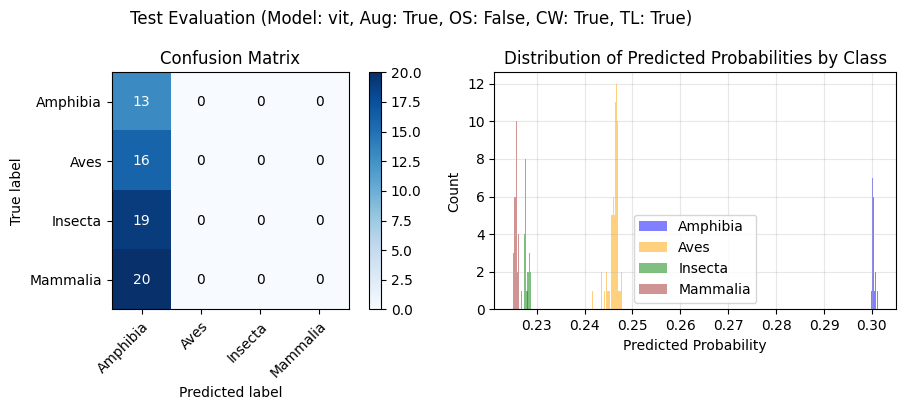

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_256vit_model_256_aug_cw_tl.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.19      1.00      0.32        13
        Aves       0.00      0.00      0.00        16
     Insecta       0.00      0.00      0.00        19
    Mammalia       0.00      0.00      0.00        20

    accuracy                           0.19        68
   macro avg       0.05      0.25      0.08        68
weighted avg       0.04      0.19      0.06        68



In [11]:
# Convert list to numpy array for easier handling
y_pred_prob = np.array(y_pred_prob_list).mean(axis=0)

# Plot training diagnostics
plot_test_evaluation(y_true, y_pred_prob, class_mapping=CLASS_MAPPING_DICT, cfg=cfg)

In [38]:
import tensorflow.keras.metrics as kmetrics
# Set up from scratch using these hp
# Best hyper-parameters:
#   lr: 0.00041424724330521253
#   dropout: 0.30000000000000004
#   vision_lr_mult: 0.25
#   dense_width: 128
#   freeze_epochs: 2
#   weight_decay: 3.390841519182325e-05
#   tuner/epochs: 30
#   tuner/initial_epoch: 10
#   tuner/bracket: 1
#   tuner/round: 1
#   tuner/trial_id: 0145

cfg.lr       = 4.142472433052125e-05  # tuned
cfg.min_lr   = 1.0e-06                  # 1 % of lr
cfg.epochs   = 30                      # from tuner
cfg.weight_decay = 3.390841519182325e-06  # tuned
cfg.freeze_epochs = 2                  # from tuner
cfg.dropout_rate = 0.3                # from tuner
cfg.vision_lr_mult = 0.25              # from tuner

# Create the model with the best hyperparameters
cosine_scheduler = get_cosine_decay_scheduler(train_df, cfg)

model = get_multimodal_vit_model(cfg=cfg)

model.compile(
    optimizer = keras.optimizers.AdamW(
        learning_rate=cosine_scheduler,  # Use scheduler instead of fixed lr
        weight_decay=cfg.weight_decay
    ),
    loss      = categorical_focal_loss(alpha=0.25, gamma=2.0),  # Use the tuned focal loss
    metrics   = [
        "accuracy",
        macro_f1_fn,
        kmetrics.AUC(name="auroc", multi_label=True, from_logits=False)
    ],
)

train_df, val_df = train_test_split(
    combined_train_val_df,
    test_size=0.20,
    stratify=combined_train_val_df["y_species_encoded"],
    random_state=42,
)

# Compute fixed data generators and steps outside (HP-independent)
train_gen = data_generator_with_metadata(
    train_df, cfg, filtered_spectrograms, metadata_features,
    class_weights=class_weights,
    is_train=True,
    yield_weight=False,
    batch_size=cfg.batch_size,
)
val_gen = data_generator_with_metadata(
    val_df, cfg, filtered_spectrograms, metadata_features,
    class_weights=None,
    is_train=False,
    yield_weight=False,
    batch_size=cfg.batch_size,
)

steps_per_epoch = get_steps(train_df, cfg, cfg.batch_size)
val_steps = get_steps(val_df, cfg, cfg.batch_size)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    ),
    # UnfreezeBackbone(           # ← no verbose kwarg
    #     freeze_epochs = cfg.freeze_epochs,
    #     lr_mult       = cfg.vision_lr_mult,   # don’t forget this
    #     key           = "vi_t_backbone",
    # ),
]


history = model.fit(
    train_gen,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_gen,
    validation_steps= val_steps,
    epochs          = cfg.epochs,
    callbacks       = callbacks,
    verbose         = 1,
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.1827 - auroc: 0.4300 - loss: 0.2424 - macro_f1_fn: 0.1159 - val_accuracy: 0.2917 - val_auroc: 0.5101 - val_loss: 0.1997 - val_macro_f1_fn: 0.2107
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2299 - auroc: 0.4730 - loss: 0.2102 - macro_f1_fn: 0.1679 - val_accuracy: 0.3194 - val_auroc: 0.4548 - val_loss: 0.1986 - val_macro_f1_fn: 0.1873
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2922 - auroc: 0.5541 - loss: 0.1893 - macro_f1_fn: 0.2387 - val_accuracy: 0.3472 - val_auroc: 0.6181 - val_loss: 0.1875 - val_macro_f1_fn: 0.2411
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3191 - auroc: 0.5359 - loss: 0.1833 - macro_f1_fn: 0.2777 - val_accuracy: 0.3472 - val_auroc: 0.6041 - val_loss: 0.1861 - val_macro_f1_fn: 0.2056
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3393 - auroc: 0.5567 - loss: 0.1678 - macro_f1_fn: 0.2547 - val_accuracy: 0.3750 - val_aur

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step

Test Loss: 1.4060
Test AUC: 0.4804
Test Accuracy: 0.2206
Training curves saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/training_curves_256vit_model_256_aug_cw_tl.png


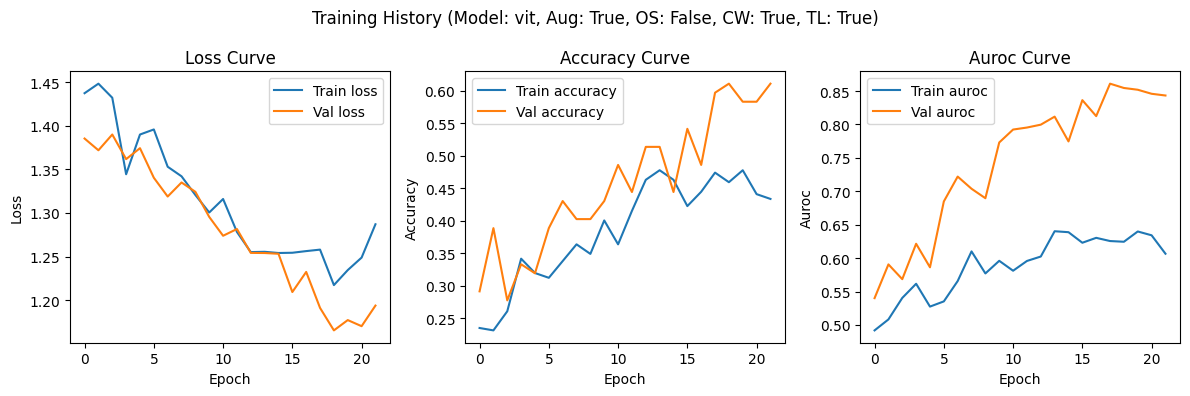

Confusion matrix saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_256vit_model_256_aug_cw_tl.png


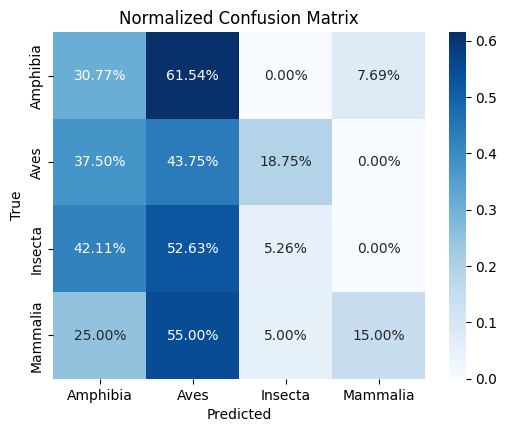

Per-class metrics saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_256vit_model_256_aug_cw_tl.png


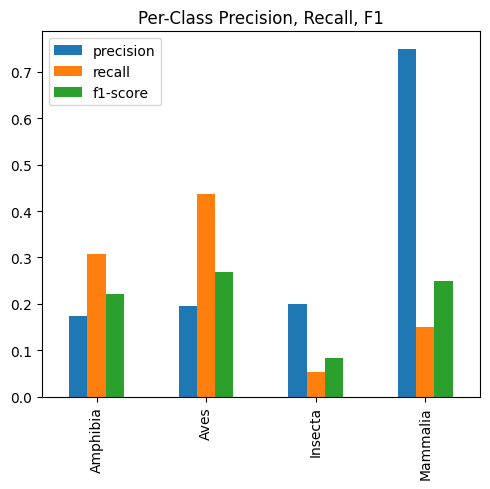

Test evaluation plot saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/test_evaluation_256vit_model_256_aug_cw_tl.png


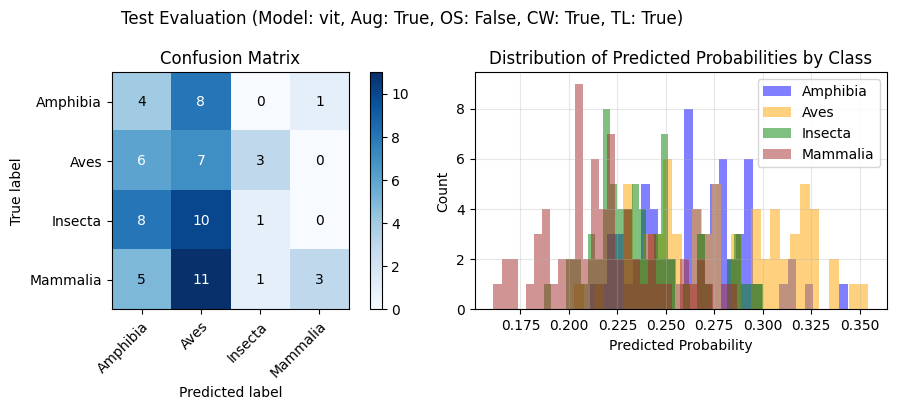

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_256vit_model_256_aug_cw_tl.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.17      0.31      0.22        13
        Aves       0.19      0.44      0.27        16
     Insecta       0.20      0.05      0.08        19
    Mammalia       0.75      0.15      0.25        20

    accuracy                           0.22        68
   macro avg       0.33      0.24      0.21        68
weighted avg       0.36      0.22      0.20        68



In [37]:
y_true, y_pred_prob = evaluate_on_test_multimodal(
    model=model,
    cfg=cfg,
    spectrograms=filtered_spectrograms,
    metadata_features=metadata_features,
    test_df=test_df,
)

# Plot training diagnostics
plot_training_diagnostics(history, cfg,  y_true, y_pred_prob, CLASS_MAPPING_DICT)
plot_test_evaluation(y_true, y_pred_prob, class_mapping=CLASS_MAPPING_DICT, cfg=cfg)